<a href="https://colab.research.google.com/github/maryamdarei/cnn-error/blob/main/CNN_with_GRADCAM_herbarium2019_2classes_addversarial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN Model With PyTorch For Image Classification

### Herbarium DataSet:

Data set is Herbarium Challenge 2019, small data set.

The Herbarium Challenge dataset is a dataset used for plant species recognition, which is a challenging task due to the large number of plant species and the subtle differences in their appearance. This dataset is a long-tail  dataset. A long-tail herbarium dataset refers to a dataset that contains a large number of plant species, but with a highly skewed distribution of instances among the species. This means that the majority of the plant species in the dataset have very few images, while a small number of species have a large number of images.
The long-tail distribution of instances in a dataset can make it challenging to train machine learning models. This is because the model may not have enough data to learn the characteristics of the minority classes, leading to poor performance on those classes. This can also lead to bias in the model's predictions, as it will be more likely to predict the majority classes. To overcome this challenge, several approaches have been proposed such as re-sampling the data, fine-tuning pre-trained models, and using advanced deep learning techniques such as transfer learning and ensembling.

Additionally, there are also recent studies on long-tail datasets that aim to improve the performance on the long-tail classes by generating synthetic data, knowledge distillation, and learning from noisy labels.

Some of the other problems that may arise when working with the Herbarium Challenge dataset include:

1- Limited data availability: The Herbarium Challenge dataset may not contain a sufficient number of images for certain plant species, leading to a lack of diversity in the training data and a higher risk of overfitting.

2- Variations in image quality: The images in the dataset may have different resolutions, lighting conditions, and angles, which can make it difficult for the model to generalize to new images.

3- Label noise: The dataset may contain errors in the labels, which can lead to inaccurate predictions and poor performance.

4- Class imbalance: Some plant species may be over-represented in the dataset, while others may be under-represented, which can lead to bias in the model's predictions.

5- Lack of data augmentation: The dataset may not have undergone data augmentation techniques such as rotation, flipping, and cropping, which can lead to a lack of robustness in the model.

To overcome these challenges, it is important to have a diverse and large dataset with good quality images, carefully curated labels, and data augmentation techniques to increase the robustness of the model. Additionally, using advanced deep learning techniques such as transfer learning and ensembling can also help to improve the performance of the model.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



The classification of herbrium using ResNet50 is a specific task that involves using a deep learning model called ResNet50 to classify different types of herbs. ResNet50 is a pre-trained CNN model that was trained on the ImageNet dataset, which contains a large number of images of various objects and scenes. The model has been trained to extract features from images and classify them into different classes.

In the classification of herbrium using ResNet50, the model is fine-tuned using a dataset of images of herbs. The dataset is likely to contain different types of herbs with different characteristics, such as leaf shape, flower color, and overall appearance. The model is then used to classify new images of herbs based on the features it has learned from the training dataset.

For example, if the model is given an image of a rosemary herb, it would use the features it has learned from the training dataset to recognize the characteristic shape of the leaves and the color of the flowers, and classify the image as "rosemary". Similarly, if the model is given an image of a mint herb, it would recognize the characteristic shape of the leaves and classify the image as "mint".

The classification of herbrium using ResNet50 is likely to be a challenging task due to the subtle differences in appearance between different types of herbs. However, by fine-tuning ResNet50 with a large and diverse dataset of herb images, the model can achieve a high level of accuracy in classifying different types of herbs.


In [ ]:
!pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x

In [2]:
import logging as log
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import ticker
from torch.utils.tensorboard import SummaryWriter


In [3]:
log.basicConfig(format="%(asctime)s %(message)s", level=log.INFO)
log.info("======= starting to log ========")
torch.cuda.empty_cache()

In [4]:
# Define relevant variables for the ML task
num_classes = 2
learning_rate = 0.001
num_epochs = 20  # actual 20 epochs
workers = 0
pin_memory = False
batch_size = 64

In [5]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


# Select the model you want to train

ResNet:

ResNet (Residual Network) is a type of deep neural network that was introduced in 2015 by researchers at Microsoft. The key innovation in ResNet is the use of residual connections, which allow the network to train deeper architectures without suffering from the vanishing gradient problem. Training a ResNet typically involves using stochastic gradient descent (SGD) with backpropagation to optimize the model's parameters with respect to a loss function, such as cross-entropy. This is done by iteratively updating the weights of the network in order to reduce the difference between the predicted output and the true output. Data augmentation techniques such as random cropping and flipping can be used to increase the diversity of the training set and improve the generalization of the model.




In [6]:
modelname = "Res50"

In [9]:

# -------------------------------------------------------------------------------------------------------
# Load the data from image folder
# -------------------------------------------------------------------------------------------------------

data_dir = "/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small"
train_dir = os.path.join(data_dir, "train")
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# I changed the code for resize the image:
train_transforms = transforms.Compose(
    [
        
        transforms.Resize((277,277)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(0.5),
        transforms.ToTensor(),
        normalize_transform,
    ]
)

val_dir = os.path.join(data_dir, "val")

val_transforms = transforms.Compose(
    [transforms.Resize((277,277)), transforms.ToTensor(), normalize_transform]
)


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


In [ ]:
foldername_to_class = {}
with open('/content/drive/MyDrive/Herbarium Data-2019/Data/categories.txt', 'r') as file:
    for index, line in enumerate(file):
        if index == 0:
            continue
        else:
            data = line.split(',')
            foldername_to_class[str(int(data[0]))] = data[1].replace('\n', '')

print(foldername_to_class)



# creating a new dictionary
#my_dict ={"java":100, "python":112, "c":11}

 
# list out keys and values separately
key_list = list(foldername_to_class.keys())
val_list = list(foldername_to_class.values())
 
print(key_list)
print(val_list)
#print key with val 100
#position = val_list.index("Siphanthera cordata Pohl ex DC.")
print(key_list[val_list.index("Siphanthera cordata Pohl ex DC.")])
        

In [ ]:
# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index", train_dataset.class_to_idx.items())
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))

categories = []
for key in sorted_vals:
    print(key)
    classname = foldername_to_class[key]
    categories.append(classname)

log.info(f"Categories {categories}")

In [12]:
# -------------------------------------------------------------------------------------------------------
# Initialise the data loaders
# -------------------------------------------------------------------------------------------------------

# ImageFile.LOAD_TRUNCATED_IMAGES = True # Use the data_checker.py and remove bad files instead of using this

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # IMPORTANT otherwise the data is not shuffled
    num_workers=workers,
    pin_memory=pin_memory,
    sampler=None,
)

test_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=pin_memory,
)


In [ ]:
#I added this line for running the model:
model = torchvision.models.resnet50()
model.to(device)


In [14]:

# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossFn = nn.CrossEntropyLoss()


## Train Model: My own function


In [15]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in train_loader:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(train_loader)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [16]:

# Write training matrics to Tensorboard
writer = SummaryWriter()

# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(train_loader):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgAccuracy = totalTrainAccuracy / len(train_loader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy))

    # End Epoch loop
writer.flush()



Epoch [1/20], Loss: 7.4531, TrainAccuracy: 0.0000 
Epoch [2/20], Loss: 2.6703, TrainAccuracy: 83.3333 
Epoch [3/20], Loss: 0.7747, TrainAccuracy: 83.3333 
Epoch [4/20], Loss: 0.2840, TrainAccuracy: 83.3333 
Epoch [5/20], Loss: 0.0062, TrainAccuracy: 100.0000 
Epoch [6/20], Loss: 0.0002, TrainAccuracy: 100.0000 
Epoch [7/20], Loss: 0.0075, TrainAccuracy: 100.0000 
Epoch [8/20], Loss: 0.0040, TrainAccuracy: 100.0000 
Epoch [9/20], Loss: 0.0013, TrainAccuracy: 100.0000 
Epoch [10/20], Loss: 0.0021, TrainAccuracy: 100.0000 
Epoch [11/20], Loss: 0.0007, TrainAccuracy: 100.0000 
Epoch [12/20], Loss: 0.0010, TrainAccuracy: 100.0000 
Epoch [13/20], Loss: 0.0006, TrainAccuracy: 100.0000 
Epoch [14/20], Loss: 0.0005, TrainAccuracy: 100.0000 
Epoch [15/20], Loss: 0.0001, TrainAccuracy: 100.0000 
Epoch [16/20], Loss: 0.0003, TrainAccuracy: 100.0000 
Epoch [17/20], Loss: 0.0004, TrainAccuracy: 100.0000 
Epoch [18/20], Loss: 0.0007, TrainAccuracy: 100.0000 
Epoch [19/20], Loss: 0.0000, TrainAccuracy

In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    print(labels)
    print(predicted)

Accuracy of the network on the 19 validation images: 100.0 %
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')


##Adversarial attack:
https://towardsdatascience.com/adversarial-attack-and-defense-on-neural-networks-in-pytorch-82b5bcd9171

In [35]:
from cleverhans.future.torch.attacks.fast_gradient_method import fast_gradient_method

In [26]:
tf.compat.v1.GraphKeys

In [36]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import warnings
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms

from cleverhans.compat import flags
#from cleverhans.train import train
from cleverhans.dataset import MNIST
from cleverhans.utils import AccuracyReport
#from cleverhans.utils_tf import model_eval

#Attack on PyTorch
from cleverhans.future.torch.attacks.fast_gradient_method import fast_gradient_method

#advertorch attacks
#from advertorch.attacks import CarliniWagnerL2Attack

In [37]:
def evalAdvAttack(fgsm_model=None, test_loader=None):
    print("Evaluating single model results on adv data")
    total = 0
    correct = 0
    fgsm_model.eval()
    for xs, ys in test_loader:
      if torch.cuda.is_available():
        xs, ys = xs.cuda(), ys.cuda()
      #pytorch fast gradient method
      xs = fast_gradient_method(fgsm_model, xs, eps=0.1, norm=np.inf, clip_min=0., clip_max=1.)
      # xs = fast_gradient_method(fgsm_model, xs, eps=0.1, norm=np.inf)
      xs, ys = Variable(xs), Variable(ys)
      preds1 = fgsm_model(xs)
      preds_np1 = preds1.cpu().detach().numpy()
      finalPred = np.argmax(preds_np1, axis=1)
      correct += (finalPred == ys.cpu().detach().numpy()).sum()
      total += test_loader.batch_size
    acc = float(correct) / total
    print('Adv accuracy: {:.3f}％'.format(acc * 100))


In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

In [44]:
def advTrain(torch_model, train_loader, test_loader,
        nb_epochs=num_epochs, batch_size=batch_size, train_end=-1, test_end=-1, learning_rate=learning_rate):
    optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

    train_loss = []
    total = 0
    correct = 0
    totalAdv = 0
    correctAdv = 0
    step = 0
    # breakstep = 0
    for _epoch in range(nb_epochs):
      for xs, ys in train_loader:
        #Normal Training
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        total += train_loader.batch_size

        #Adversarial Training
        xs = fast_gradient_method(torch_model, xs, eps=0.3, norm=np.inf, clip_min=0., clip_max=1.)
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correctAdv += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        totalAdv += train_loader.batch_size
        step += 1
        #if total % 1000 == 0:
        acc = float(correct) / total
        print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
        total = 0
        correct = 0
        accAdv = float(correctAdv) / totalAdv
        print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))
        totalAdv = 0
        correctAdv = 0
        #print("2222")


In [45]:
advTrain(model, train_loader, test_loader, nb_epochs=num_epochs, batch_size=batch_size, train_end=-1, test_end=-1, learning_rate=learning_rate)

[1] Clean Training accuracy: 9.38%
[1] Adv Training accuracy: 9.38%
[2] Clean Training accuracy: 9.38%
[2] Adv Training accuracy: 9.38%
[3] Clean Training accuracy: 9.38%
[3] Adv Training accuracy: 9.38%
[4] Clean Training accuracy: 9.38%
[4] Adv Training accuracy: 9.38%
[5] Clean Training accuracy: 9.38%
[5] Adv Training accuracy: 9.38%
[6] Clean Training accuracy: 9.38%
[6] Adv Training accuracy: 9.38%
[7] Clean Training accuracy: 9.38%
[7] Adv Training accuracy: 9.38%
[8] Clean Training accuracy: 9.38%
[8] Adv Training accuracy: 9.38%
[9] Clean Training accuracy: 9.38%
[9] Adv Training accuracy: 9.38%
[10] Clean Training accuracy: 9.38%
[10] Adv Training accuracy: 9.38%
[11] Clean Training accuracy: 9.38%
[11] Adv Training accuracy: 9.38%
[12] Clean Training accuracy: 9.38%
[12] Adv Training accuracy: 9.38%
[13] Clean Training accuracy: 9.38%
[13] Adv Training accuracy: 9.38%
[14] Clean Training accuracy: 9.38%
[14] Adv Training accuracy: 9.38%
[15] Clean Training accuracy: 9.38%
[1

In [47]:

# Write training matrics to Tensorboard
writer = SummaryWriter()

# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(train_loader):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                advimages = fast_gradient_method(model, images, eps=0.9, norm=np.inf, clip_min=0., clip_max=1.)
                # perform a forward pass and calculate the training loss
                outputs = model(advimages)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgAccuracy = totalTrainAccuracy / len(train_loader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy))

    # End Epoch loop
writer.flush()



Epoch [1/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [2/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [3/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [4/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [5/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [6/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [7/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [8/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [9/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [10/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [11/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [12/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [13/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [14/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [15/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [16/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [17/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [18/20], Loss: 0.0000, TrainAccuracy: 100.0000 
Epoch [19/20], Loss: 0.0000, TrainAcc

In [48]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        advimages = fast_gradient_method(model, images, eps=0.3, norm=np.inf, clip_min=0., clip_max=1.)
        outputs = model(advimages)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    print(labels)
    print(predicted)

RuntimeError: ignored

## Test and Analyse the Model

Testing a CNN model with ResNet50 would involve using a dataset of images that the model has not seen during training. The goal of testing is to evaluate the model's performance on unseen data and to estimate its generalization error.

To test a CNN model with ResNet50, you would first need to load the pre-trained weights of the model. This can be done using a library such as PyTorch, which provide pre-trained ResNet50 models that can be easily loaded and used for testing.

Once the model is loaded, you would need to prepare your test dataset by preprocessing the images (e.g. resizing, normalizing) and labels in the same way as the training dataset. Then, you can use the model to make predictions on the test dataset by passing the images through the model and comparing the model's predictions to the true labels.


In [ ]:
# Save the model
#/content/drive/MyDrive/Herbarium Data-2019/SavedModel
modelname ="resnet50"
path = "/content/drive/MyDrive/Herbarium Data-2019/SavedModel"
model_save_name = path + modelname + datetime.now().strftime("%H:%M_%B%d%Y")
torch.save(model.state_dict(), model_save_name + ".pth")
log.info(f"Model {modelname} saved as {model_save_name}")


## Adversarial attack:

https://towardsdatascience.com/adversarial-attack-and-defense-on-neural-networks-in-pytorch-82b5bcd9171

In [ ]:
!pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x

#Adversarial attack

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [ ]:
model = model.eval()

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        #print(target.shape)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        #print(output.shape)
        #print(init_pred.shape)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.05	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.1	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 49 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 49 = 0.0


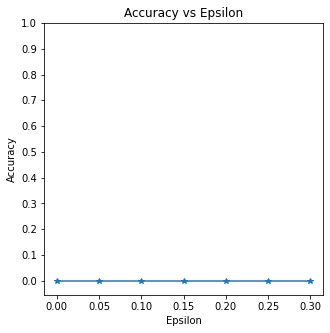

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

#second method

In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 17.2 MB/s eta 0:00:00


In [ ]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..')
import torchattacks

In [ ]:
from torchattacks import PGD
#from utils import imshow, get_pred

In [ ]:
atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
print(atk)

PGD(model_name=ResNet, device=cuda:0, return_type=float, attack_mode=default, targeted=False, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


In [ ]:
adv_images = atk(images, labels)

In [ ]:
print(adv_images)

In [ ]:
#When normalization used:
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Analyse Model:

A confusion matrix is a table that is often used to evaluate the performance of a classifier, such as a CNN. The matrix is used to compare the predicted class labels with the true class labels of the test set. The rows of the matrix represent the true class labels, while the columns represent the predicted class labels.


The confusion matrix allows you to see which classes the model is confused between, and can give you a better understanding of the performance of your model. From the matrix, you can also calculate some performance metrics such as accuracy, precision, recall, and F1-score.

We use a confusion matrix to evaluate the model's performance. It shows the number of times each class was predicted as another class, and provides a visual representation of the model's accuracy and errors.

## Confusion Matrix for training Data:

In [ ]:
# Generate the Confusion Matrix

print('Training Analyse:')
print('\n')


confusion_matrix = np.zeros((len(categories), len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval()  # IMPORTANT set model to eval mode before inference

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(
            images
        )  # Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(
            outputs.data, 1
        )  # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask = predicted != labels  # Wrongly predicted
        wrong_predicted = torch.masked_select(predicted, mask)
        wrong_labels = torch.masked_select(labels, mask)
        wrongly_zipped = zip(wrong_labels, wrong_predicted)


        mask = predicted == labels  # Rightly predicted
        rightly_predicted = torch.masked_select(predicted, mask)
        right_labels = rightly_predicted  # same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels, rightly_predicted)

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(wrongly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(rightly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

    # print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    #print(categories)
    for i in range(len(categories)):
        for j in range(len(categories)):
            print(f"\t{confusion_matrix[i][j]}", end="")
        print(f"\t{categories[i]}\n", end="")
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    print("---------------------------------------")
    print(
        f"Accuracy/precision from confusion matrix from training is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}"
    )
    print("---------------------------------------")
    for i in range(len(categories)):
        print(
            f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}"
        )
print('\n')
print('\n')

print('Testing Analyse:')
print('\n')





# Generate the Confusion Matrix

confusion_matrix = np.zeros((len(categories), len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval()  # IMPORTANT set model to eval mode before inference

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(
            images
        )  # Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(
            outputs.data, 1
        )  # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask = predicted != labels  # Wrongly predicted
        wrong_predicted = torch.masked_select(predicted, mask)
        wrong_labels = torch.masked_select(labels, mask)
        wrongly_zipped = zip(wrong_labels, wrong_predicted)

        mask = predicted == labels  # Rightly predicted
        rightly_predicted = torch.masked_select(predicted, mask)
        right_labels = rightly_predicted  # same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels, rightly_predicted)

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(wrongly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(rightly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

    # print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    #print(categories)
    for i in range(len(categories)):
        for j in range(len(categories)):
            print(f"\t{confusion_matrix[i][j]}", end="")
        print(f"\t{categories[i]}\n", end="")
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    print("---------------------------------------")
    print(
        f"Accuracy/precision from confusion matrix for testing is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}"
    )
    print("---------------------------------------")
    for i in range(len(categories)):
        print(
            f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}"
        )


    # ---------------------------------------------------
    # Plot this in a good figure
    # ---------------------------------------------------

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.title("Confusion Matrix", fontsize=8)
    # ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.7)
    # #ax.set_xticklabels([""] + categories, rotation=90)
    # ax.set_yticklabels([""] + categories)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # for i in range(confusion_matrix.shape[0]):
    #     for j in range(confusion_matrix.shape[1]):
    #         ax.text(
    #             x=j,
    #             y=i,
    #             s=int(confusion_matrix[i, j]),
    #             va="center",
    #             ha="center",
    #             size="xx-small",
    #         )
    #         if i == j:
    #             acc = round(confusion_matrix[i][i] / confusion_matrix[i].sum(), 2)
    #             ax.text(
    #                 x=len(categories) + 1,
    #                 y=i,
    #                 s=acc,
    #                 va="center",
    #                 ha="center",
    #                 size="xx-small",
    #             )
    # plt.savefig(model_save_name + "_cm.jpg")

Training Analyse:


	0.0	2.0	Miconia approximata Gamba & Almeda
	0.0	4.0	Miconia ibaguensis (Bonpl.) Triana
---------------------------------------
Accuracy/precision from confusion matrix from training is 0.67
---------------------------------------
---Accuracy for class Miconia approximata Gamba & Almeda = 0.0
---Accuracy for class Miconia ibaguensis (Bonpl.) Triana = 1.0




Testing Analyse:


	1.0	1.0	Miconia approximata Gamba & Almeda
	2.0	15.0	Miconia ibaguensis (Bonpl.) Triana
---------------------------------------
Accuracy/precision from confusion matrix for testing is 0.84
---------------------------------------
---Accuracy for class Miconia approximata Gamba & Almeda = 0.5
---Accuracy for class Miconia ibaguensis (Bonpl.) Triana = 0.88


<ipython-input-25-c7f89ced8a51>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + categories)
<ipython-input-25-c7f89ced8a51>:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + categories)


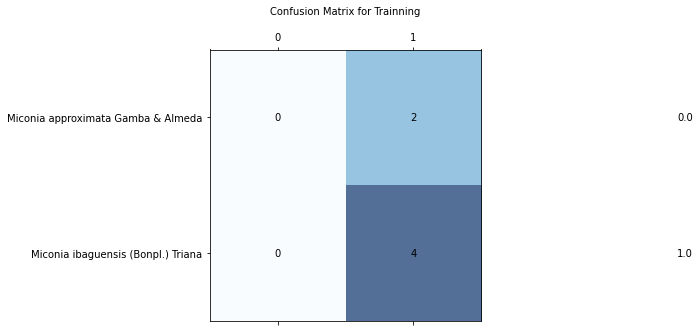

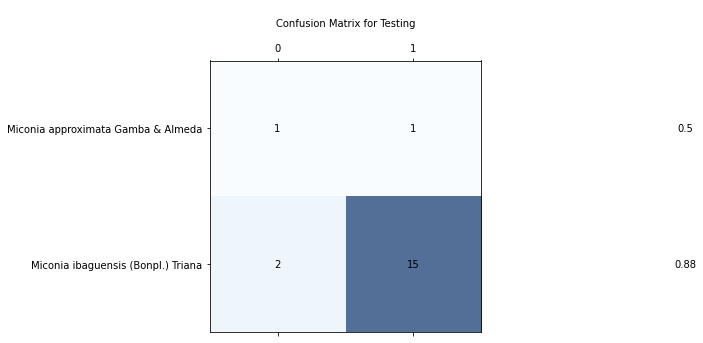

In [ ]:
# Generate the Confusion Matrix

confusion_matrix = np.zeros((len(categories), len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval()  # IMPORTANT set model to eval mode before inference

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(
            images
        )  # Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(
            outputs.data, 1
        )  # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask = predicted != labels  # Wrongly predicted
        wrong_predicted = torch.masked_select(predicted, mask)
        wrong_labels = torch.masked_select(labels, mask)
        wrongly_zipped = zip(wrong_labels, wrong_predicted)

        mask = predicted == labels  # Rightly predicted
        rightly_predicted = torch.masked_select(predicted, mask)
        right_labels = rightly_predicted  # same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels, rightly_predicted)

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(wrongly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(rightly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

    # print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    #print(categories)
    #for i in range(len(categories)):
        #for j in range(len(categories)):
            #print(f"\t{confusion_matrix[i][j]}", end="")
        #print(f"\t{categories[i]}\n", end="")
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    #print("---------------------------------------")
    #print(
    #    f"Accuracy/precision from confusion matrix is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}"
    #)
    #print("---------------------------------------")
    #for i in range(len(categories)):
    #    print(
    #        f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}"
    #    )

    # ---------------------------------------------------
    # Plot this in a good figure
    # ---------------------------------------------------

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title("Confusion Matrix for Trainning\n", fontsize=10)
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.7)
    #ax.set_xticklabels([""] + categories, rotation=90)
    ax.set_yticklabels([""] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(
                x=j,
                y=i,
                s=int(confusion_matrix[i, j]),
                va="center",
                ha="center",
                size="medium",
            )
            if i == j:
                acc = round(confusion_matrix[i][i] / confusion_matrix[i].sum(), 2)
                ax.text(
                    x=len(categories) + 1,
                    y=i,
                    s=acc,
                    va="center",
                    ha="center",
                    size="medium",
                )
    plt.savefig(model_save_name + "_cm.jpg")


# Generate the Confusion Matrix





confusion_matrix = np.zeros((len(categories), len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval()  # IMPORTANT set model to eval mode before inference

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(
            images
        )  # Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(
            outputs.data, 1
        )  # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask = predicted != labels  # Wrongly predicted
        wrong_predicted = torch.masked_select(predicted, mask)
        wrong_labels = torch.masked_select(labels, mask)
        wrongly_zipped = zip(wrong_labels, wrong_predicted)

        mask = predicted == labels  # Rightly predicted
        rightly_predicted = torch.masked_select(predicted, mask)
        right_labels = rightly_predicted  # same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels, rightly_predicted)

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(wrongly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(rightly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

    # print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    # print(categories)
    # for i in range(len(categories)):
    #     for j in range(len(categories)):
    #         print(f"\t{confusion_matrix[i][j]}", end="")
    #     print(f"\t{categories[i]}\n", end="")
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    # print("---------------------------------------")
    # print(
    #     f"Accuracy/precision from confusion matrix is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}"
    # )
    # print("---------------------------------------")
    # for i in range(len(categories)):
    #     print(
    #         f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}"
    #     )

    # ---------------------------------------------------
    # Plot this in a good figure
    # ---------------------------------------------------
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title("\nConfusion Matrix for Testing\n", fontsize=10)
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.7)
    #ax.set_xticklabels([""] + categories, rotation=90)
    ax.set_yticklabels([""] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(
                x=j,
                y=i,
                s=int(confusion_matrix[i, j]),
                va="center",
                ha="center",
                size="medium",
            )
            if i == j:
                acc = round(confusion_matrix[i][i] / confusion_matrix[i].sum(), 2)
                ax.text(
                    x=len(categories) + 1,
                    y=i,
                    s=acc,
                    va="center",
                    ha="center",
                    size="medium",
                )          
    plt.savefig(model_save_name + "_cm.jpg")





## Predict a score for each class label

In this process, a set of images is used to evaluate the performance of a pre-trained CNN model. The model uses its learned features to analyze each image and predict the class label that it believes the image belongs to. For each image, the model generates a score for each class label, indicating the likelihood that the image belongs to that class. The class label with the highest score is considered the model's prediction for that image. Additionally, the class label with the lowest score can give an insight into the classes that the model is certain the image does not belong to.

For example, if the model is trained to recognize different types of animals, and it is given an image of a dog, the model will generate scores for different class labels such as "dog", "cat", "horse", "bird", etc. The class label "dog" might have the highest score (e.g. 0.95) indicating that the model is very confident that the image is of a dog. The class label "cat" might have a lower score (e.g. 0.05) indicating that the model is certain that the image is not of a cat.

This scoreboard of predictions along with the technique called GradCAM (Gradient-weighted Class Activation Mapping) can help us understand how the model arrived at its predictions. GradCAM is a technique that allows us to visualize which parts of an image the model is focusing on when making its predictions. For example, if the model is given an image of a dog, the GradCAM visualization might show that the model is focusing on the eyes, ears and nose of the dog, which are known to be key features for identifying dogs.


By analyzing the predictions, scores and GradCAM, we can evaluate the model's performance, identify potential areas for improvement, and gain a better understanding of how the model interprets images and makes predictions.






In [ ]:
from importlib.resources import path
from PIL import Image
from torchvision import transforms,datasets
import torch
#from models import resnet, alexnet, mycnn, mycnn2
import os

In [ ]:
model = model.eval()

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} validation images: {} %'.format(19, 100 * correct / total))
    print(labels)
    print(predicted)

Accuracy of the network on the 19 validation images: 36.734693877551024 %
tensor([9], device='cuda:0')
tensor([4], device='cuda:0')


In [ ]:

#path = "cnn/saved_models/" +path
resize_to = transforms.Resize((227, 227))
#model.load_state_dict(torch.load(path))
model.eval()
directory = '/content/drive/MyDrive/Herbarium Data-2019/Data/sample/val'

# use os.listdir() to get a list of all files in the directory
files = os.listdir(directory)
for filename in files:
  #print(filename)
  img_files = os.listdir('/content/drive/MyDrive/Herbarium Data-2019/Data/sample/val/'+filename)
  for img_file in img_files:
    
    input_image = Image.open('/content/drive/MyDrive/Herbarium Data-2019/Data/sample/val/'+filename+"/"+img_file)
    preprocess = transforms.Compose(
          [
              resize_to,
              transforms.ToTensor(),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
              ),  # IMPORTANT: normalize for pretrained models
          ]
    )
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
      input_batch = input_batch.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)
    x , y = torch.topk(probabilities, 1) 
    #print(categories[y])
    print("real class name: ", foldername_to_class[str(filename)])
    print(f"image {img_file} Detecting for class {categories[y]} by model {modelname}")
    #print(f"Detecting for class {img_file + foldername_to_class[str(filename)} +  model {modelname}")
    print("--")
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 2)
    #top1_prob, top1_catid = torch.topk(probabilities, )
    #print(categories[top1_catid[i]])
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    print("--------------------------------")

real class name:  Miconia approximata Gamba & Almeda
image 00000.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model resnet50
--
Miconia ibaguensis (Bonpl.) Triana 0.9988808035850525
Leandra nianga (DC.) Cogn. 0.00031030483660288155
--------------------------------
real class name:  Miconia approximata Gamba & Almeda
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model resnet50
--
Miconia ibaguensis (Bonpl.) Triana 0.9208357930183411
Miconia racemosa (Aubl.) DC. 0.03880436718463898
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00000.jpg Detecting for class Miconia approximata Gamba & Almeda by model resnet50
--
Miconia approximata Gamba & Almeda 0.8307366371154785
Miconia racemosa (Aubl.) DC. 0.14782847464084625
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00001.jpg Detecting for class Miconia ibaguensis (Bonpl.) Triana by model resnet50
--
Miconia iba

**Utility to check Precision and Recall of a  trained model Author - Alex Punnen**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import logging as log
import os
import sklearn.metrics as skmc 


In [ ]:
log.basicConfig(format="%(asctime)s %(message)s", level=log.INFO)
torch.cuda.empty_cache()

In [ ]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


## Analyse Model:
***Model Explain-ability GradCam***
Gradcam helps one visualize which parts of the images are important for the CNN when it classifies an object with high probability. After testing a model, you can use this to visualize and debug the test results.



Gradient-weighted Class Activation Mapping (***Grad-CAM***) is a technique for visualizing the regions in an image that are most important for a given classification decision made by a Convolutional Neural Network (CNN). Grad-CAM uses the gradients of the final convolutional layer of a CNN to generate a heatmap, which highlights the regions of the input image that have the strongest influence on the classification decision, however I use the gradients of all convolutional layer of a ResNet to generate a heatmap.

One of the key advantages of Grad-CAM is that it can be applied to any CNN architecture, regardless of the number of layers or the specific architecture used. Additionally, Grad-CAM can be used to generate visual explanations for any class in the dataset, rather than just the top-scoring class.

In summary, Grad-CAM is a technique that can be used to understand the internal workings of a CNN by visualizing the regions of an image that are most important for a given classification decision. It works by using the gradients of the final convolutional layer to generate a heatmap, which highlights the regions of the input image that have the strongest influence on the classification decision.


In [ ]:
!pip install grad_cam

In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


from importlib.resources import path
from PIL import Image
from torchvision import transforms, datasets
import torch
#from models import resnet, alexnet, mycnn, mycnn2
import numpy as np
import os
import torch.nn as nn

In [ ]:

def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(loopthrough(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(loopthrough(n))
        except:
            ret.append(modules)
    return flatten_list(ret)

## Set the target for the CAM layer:

To generate a Class Activation Map (CAM), you typically use the output of the last fully connected layer of your model as the input to the CAM layer. This output represents the class scores for the input image, and the CAM layer generates a heatmap highlighting the regions of the image that are most important for the model's classification decision.

However, when we use a pre-trained model such as ResNet50, the architecture is more complex and has multiple layers. In this case, to create a Grad-CAM, which is a variant of CAM, we add all the ResNet50 layers to the model, including convolutional and pooling layers, in order to compute the gradients of the last convolutional layer with respect to the output of the fully connected layer. Then, the gradients are used to weight the feature maps from the last convolutional layer and generate the CAM heatmap.


In [ ]:
# Set the target for the CAM layer; Add all the layers in the model
target_layers =[]
module_list =[module for module in model.modules()]


flatted_list= flatten_model(module_list)


print("------------------------")
for count, value in enumerate(flatted_list):
    
    if isinstance(value, (nn.Conv2d,nn.AvgPool2d,nn.BatchNorm2d)):
    #if isinstance(value, (nn.Conv2d)):
        print(count, value)
        target_layers.append(value)

print("------------------------")


In [ ]:
# Alternative is to add specific layers and check
# if modelname=='resnet50':
#     #target_layers = [module_list[142],module_list[143],module_list[144],module_list[145],module_list[146],module_list[147]]
#     target_layers = [module_list[35],module_list[36],module_list[37],module_list[38],module_list[39],module_list[40]]
# if modelname=='mycnn':
#     target_layers = [module_list[11],module_list[8],module_list[5],module_list[2],module_list[4],module_list[7],module_list[10],module_list[13]] # CNN and Avg pooling
#     #target_layers = [module_list[11],module_list[8],module_list[5],module_list[2]] # CNN only
    
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
gradvariantname = "GradCAM_"



real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00000.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconia approximata Gamba & Almeda 0.9973824620246887
Miconia ibaguensis (Bonpl.) Triana 0.002610138151794672
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00001.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconia approximata Gamba & Almeda 0.9979720711708069
Miconia ibaguensis (Bonpl.) Triana 0.002022763481363654
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00002.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconia approximata Gamba & Almeda 0.9973794221878052
Miconia ibaguensis (Bonpl.) Triana 0.0026140683330595493
--------------------------------
real class name:  Miconia ibaguensis (Bonpl.) Triana
image 00003.jpg Detecting for class Miconia approximata Gamba & Almeda by model Res50
-
Miconi

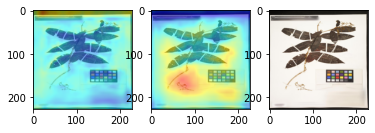

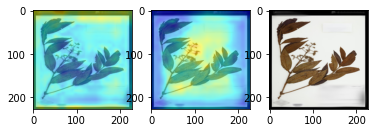

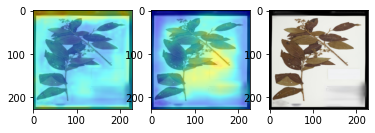

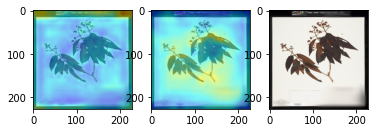

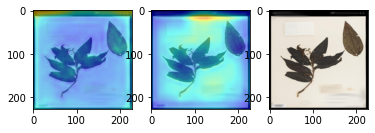

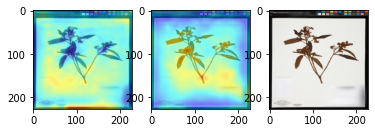

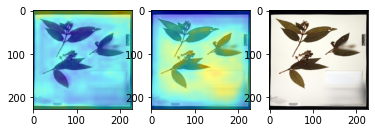

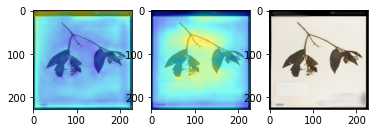

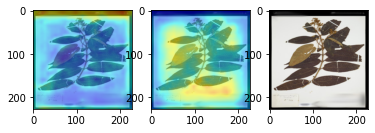

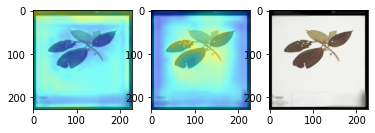

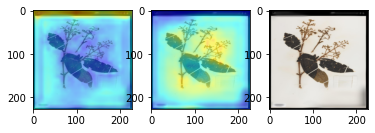

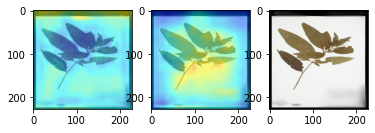

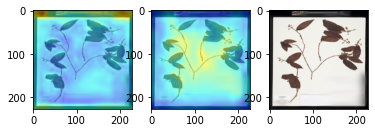

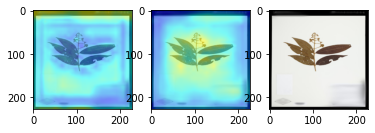

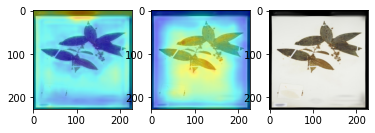

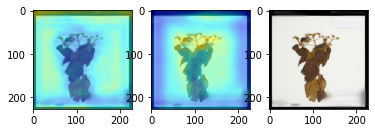

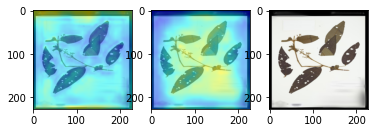

In [ ]:
# Load the images
#/content/drive/MyDrive/Model Data/test-images


resize_size =(227,227)
#path = "cnn/saved_models/" +path
resize_to = transforms.Resize((227, 227))
#model.load_state_dict(torch.load(path))
model.eval()
directory = '/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val'

# use os.listdir() to get a list of all files in the directory
files = os.listdir(directory)
for filename in files:
  #print(filename)
  img_files = os.listdir('/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val/'+filename)
  for img_file in img_files:
    #print(img_file)
    input_image = Image.open('/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val/'+filename+"/"+img_file)
    preprocess = transforms.Compose(
          [
              resize_to,
              transforms.ToTensor(),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
              ),  # IMPORTANT: normalize for pretrained models
          ]
    )
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
      input_batch = input_batch.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)
    x , y = torch.topk(probabilities, 1) 
    #print(categories[y])
    print("real class name: ", foldername_to_class[str(filename)])
    print(f"image {img_file} Detecting for class {categories[y]} by model {modelname}")
    #print(f"Detecting for class {img_file + foldername_to_class[str(filename)} +  model {modelname}")
    print("-")
    # Show top categories per image

    top5_prob, top5_catid = torch.topk(probabilities, 2)
    #top1_prob, top1_catid = torch.topk(probabilities, )
    #print(categories[top1_catid[i]])
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("--------------------------------")

    #print("this")
    if categories[y] != foldername_to_class[filename]:
      
      targets0 = [ClassifierOutputTarget(0)] #0 for finch ?
      targets1 = [ClassifierOutputTarget(1)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam0 = cam(input_batch, targets=targets0,aug_smooth=True)
      grayscale_cam1 = cam(input_batch, targets=targets1,aug_smooth=True)
      #print( "len grayscale_cam",len(grayscale_cam),grayscale_cam.shape)

      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam0 = grayscale_cam0[0, :]
      grayscale_cam1 = grayscale_cam1[0, :]


      img=np.array(input_image.resize(resize_size),np.float32)
      img = img.reshape(img.shape[1],img.shape[0],img.shape[2])
      #print("img shape",img.shape,img.max())
      img = img/255
      visualization0 = show_cam_on_image(img, grayscale_cam0, use_rgb=True)
      visualization1 = show_cam_on_image(img, grayscale_cam1, use_rgb=True)
      #cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(input_image, grayscale_cam)]
      visualization0 = Image.fromarray(visualization0)
      visualization1 = Image.fromarray(visualization1)
      #print("this")
      #out_file_name ="/content/drive/MyDrive/Herbarium Data-2019/Check2/" +modelname+ "_"+gradvariantname+ "_" + foldername_to_class[filename] + "_" +os.path.basename(filename)
      #print("this")
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(visualization0, cmap='gray')
      ax[1].imshow(visualization1, cmap='gray')
      ax[2].imshow(input_image.resize(resize_size), cmap='gray')
      #visualization.save(out_file_name)
      #print("Visualization saved- now trying to show (GUI mode)")
      #im = Image.open(out_file_name)
      #im.show()



Input Tensor Shape: torch.Size([3, 227, 227])


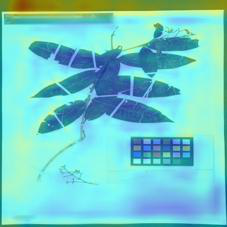

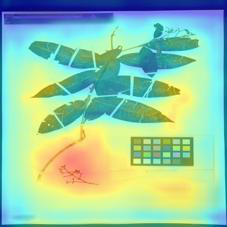

Input Tensor Shape: torch.Size([3, 227, 227])


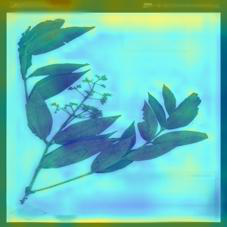

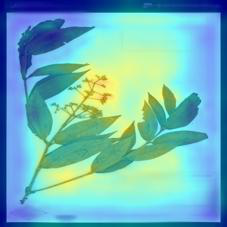

Input Tensor Shape: torch.Size([3, 227, 227])


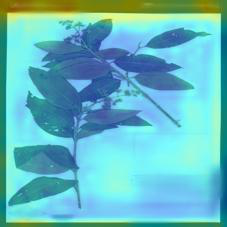

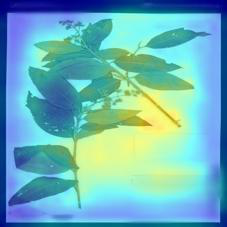

Input Tensor Shape: torch.Size([3, 227, 227])


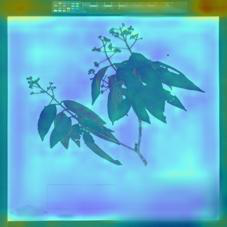

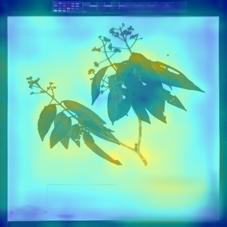

Input Tensor Shape: torch.Size([3, 227, 227])


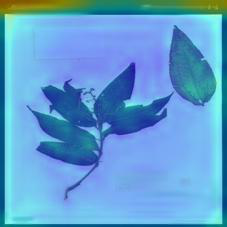

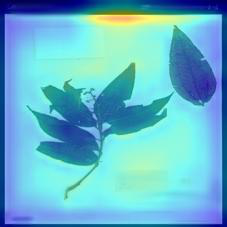

Input Tensor Shape: torch.Size([3, 227, 227])


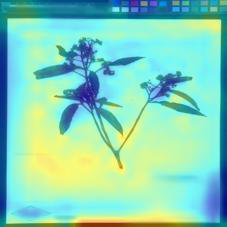

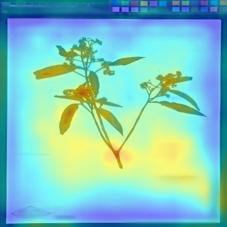

Input Tensor Shape: torch.Size([3, 227, 227])


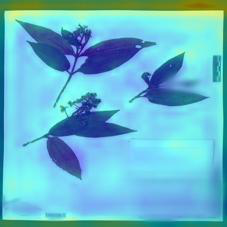

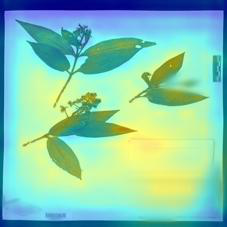

Input Tensor Shape: torch.Size([3, 227, 227])


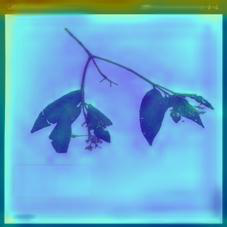

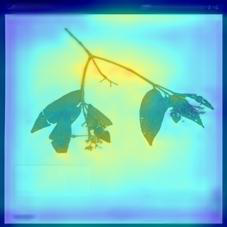

Input Tensor Shape: torch.Size([3, 227, 227])


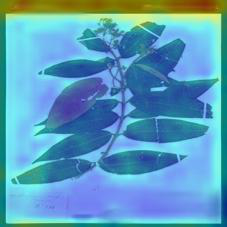

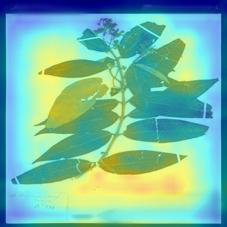

Input Tensor Shape: torch.Size([3, 227, 227])


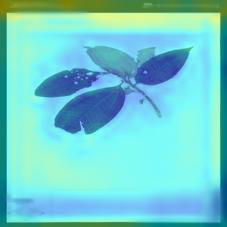

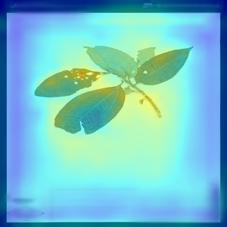

Input Tensor Shape: torch.Size([3, 227, 227])


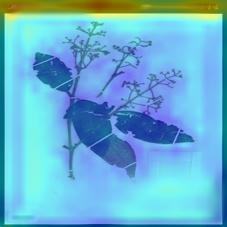

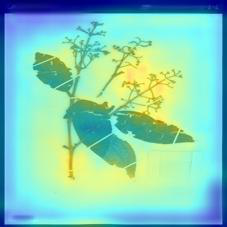

Input Tensor Shape: torch.Size([3, 227, 227])


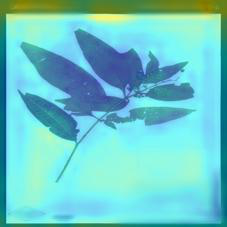

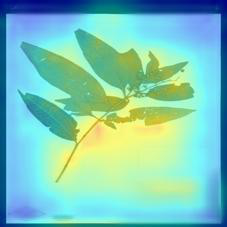

Input Tensor Shape: torch.Size([3, 227, 227])


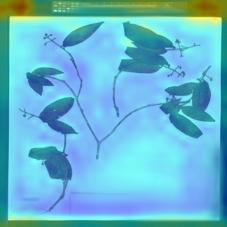

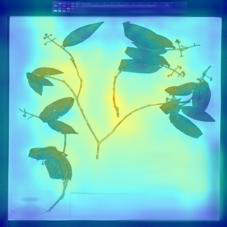

Input Tensor Shape: torch.Size([3, 227, 227])


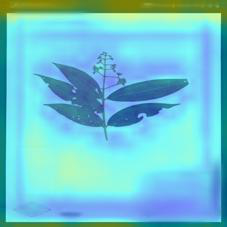

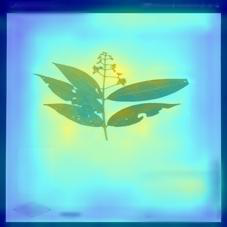

Input Tensor Shape: torch.Size([3, 227, 227])


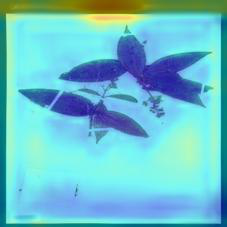

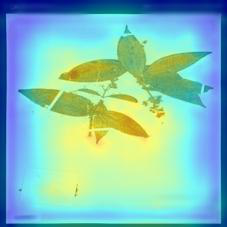

Input Tensor Shape: torch.Size([3, 227, 227])


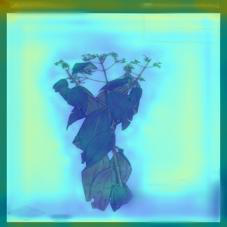

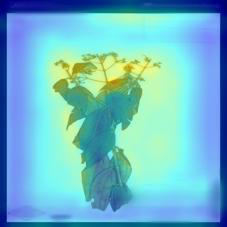

Input Tensor Shape: torch.Size([3, 227, 227])


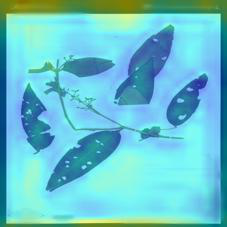

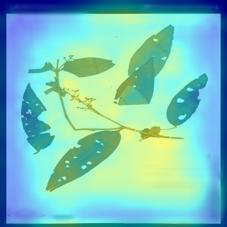

Input Tensor Shape: torch.Size([3, 227, 227])


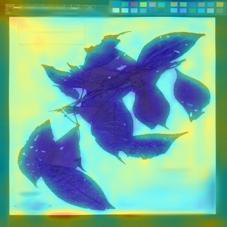

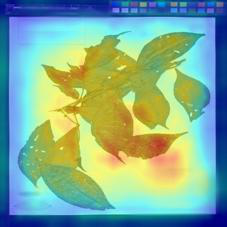

Input Tensor Shape: torch.Size([3, 227, 227])


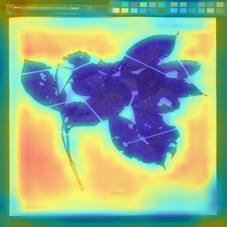

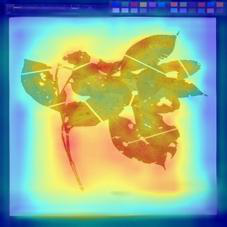

In [ ]:
# Load the images
#/content/drive/MyDrive/Model Data/test-images

resize_size =(227,227)

directory = '/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val'

# use os.listdir() to get a list of all files in the directory
files = os.listdir(directory)
for foldername in files:
  img_files = os.listdir('/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val/'+foldername)
  for filename in img_files:
      input_image = Image.open('/content/drive/MyDrive/Herbarium Data-2019/Data/sample_small/val/'+foldername +'/' +filename)

      preprocess = transforms.Compose(
          [
              resize_to,
              transforms.ToTensor(),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
              ),  # IMPORTANT: normalize for pre-trained models
          ]
      )
      input_tensor = preprocess(input_image)
      print("Input Tensor Shape:", input_tensor.shape)
      input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
      # move the input and model to GPU for speed if available
      if torch.cuda.is_available():
          input_batch = input_batch.to("cuda")
          model.to("cuda")
          input_tensor = input_tensor.to("cuda")

      # We have to specify the target we want to generate
      # the Class Activation Maps for.
      # If targets is None, the highest scoring category
      # will be used for every image in the batch.
      # Here we use ClassifierOutputTarget, but you can define your own custom targets

      # That are, for example, combinations of categories, or specific outputs in a non standard model.
      targets0 = [ClassifierOutputTarget(0)] #0 for finch ?
      targets1 = [ClassifierOutputTarget(1)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam0 = cam(input_batch, targets=targets0,aug_smooth=True)
      grayscale_cam1 = cam(input_batch, targets=targets1,aug_smooth=True)
      #print( "len grayscale_cam",len(grayscale_cam),grayscale_cam.shape)

      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam0 = grayscale_cam0[0, :]
      grayscale_cam1 = grayscale_cam1[0, :]

      # from PIL import Image
      # im = Image.fromarray(grayscale_cam)
      # if im.mode != 'RGB':
      #     im = im.convert('L')
      # im.save("grayscale_cam.jpeg"

  #/content/drive/MyDrive/Model Data/gradcam_out

      img=np.array(input_image.resize(resize_size),np.float32)
      img = img.reshape(img.shape[1],img.shape[0],img.shape[2])
      #print("img shape",img.shape,img.max())
      img = img/255
      visualization0 = show_cam_on_image(img, grayscale_cam0, use_rgb=True)
      visualization1 = show_cam_on_image(img, grayscale_cam1, use_rgb=True)
      #cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(input_image, grayscale_cam)]
      visualization0 = Image.fromarray(visualization0)
      visualization1 = Image.fromarray(visualization1)
      out_file_name0 ="/content/drive/MyDrive/Herbarium Data-2019/all_Grad_plot/" +modelname+ "_GradCAM for Miconia approximata Gamba & Almeda_"+gradvariantname+ "_" + foldername_to_class[os.path.basename(foldername)] + "_" +os.path.basename(filename)
      out_file_name1 ="/content/drive/MyDrive/Herbarium Data-2019/all_Grad_plot/" +modelname+ "_Grad for Miconia ibaguensis (Bonpl.) Triana_"+gradvariantname+ "_" + foldername_to_class[os.path.basename(foldername)] + "_" +os.path.basename(filename)
      visualization0.save(out_file_name0)
      visualization1.save(out_file_name1)
      #print("Visualization saved- now trying to show (GUI mode)")
      im0 = Image.open(out_file_name0)
      im1 = Image.open(out_file_name1)
      im0.show()
      im1.show()
    



## final GradCAM Analysis:

Using Grad-CAM (Gradient-weighted Class Activation Mapping) is a great way to visualize which regions of an input image were most important for a model's classification decision. By plotting the heatmap generated by the Grad-CAM method on top of the input image, you can see which parts of the image the model paid attention to when making its prediction.

When you are reviewing the test images and their corresponding heatmaps, you can check the score calculated by the model for each class, and try to understand how the model arrived at its decision by looking at the regions of the image highlighted by the heatmap. For example, if the model predicted that a given image is of a dog, and the heatmap shows that the model paid attention to the ears and nose of the animal, it's likely that the model has learned to recognize those features as indicative of a dog.

In addition, by using the Gerdcam method, the heatmap will be specific to the class that the image was predicted to be, so it will be more interpretable in terms of understanding the image feature that the model used to classify that specific class.

It's important to note that the heatmap generated by Grad-CAM is an approximate representation of the model's attention and it's not intended to be a definitive explanation of the model's decision-making process. But it can be used as a tool to gain insights into a model's behavior, and to identify areas for improvement in the training data or model architecture.





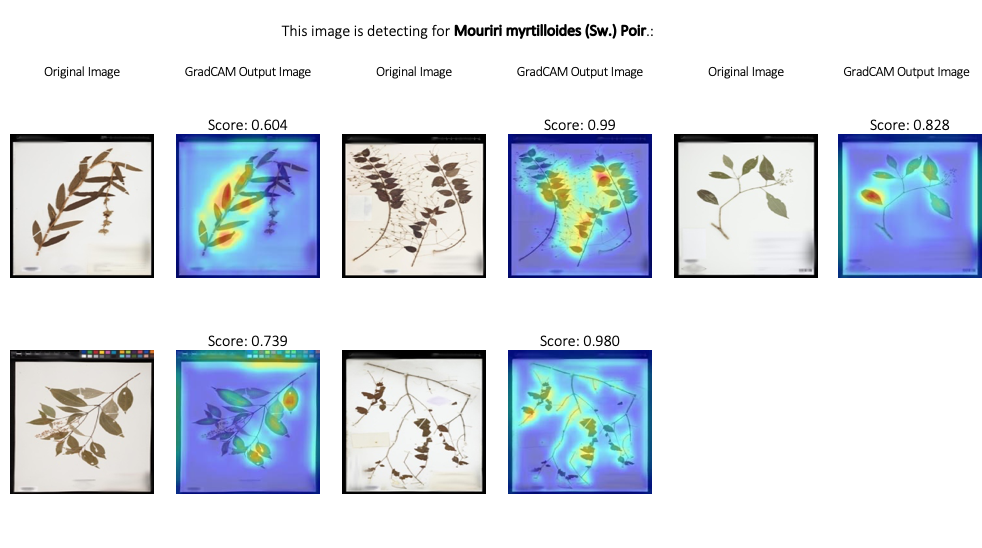

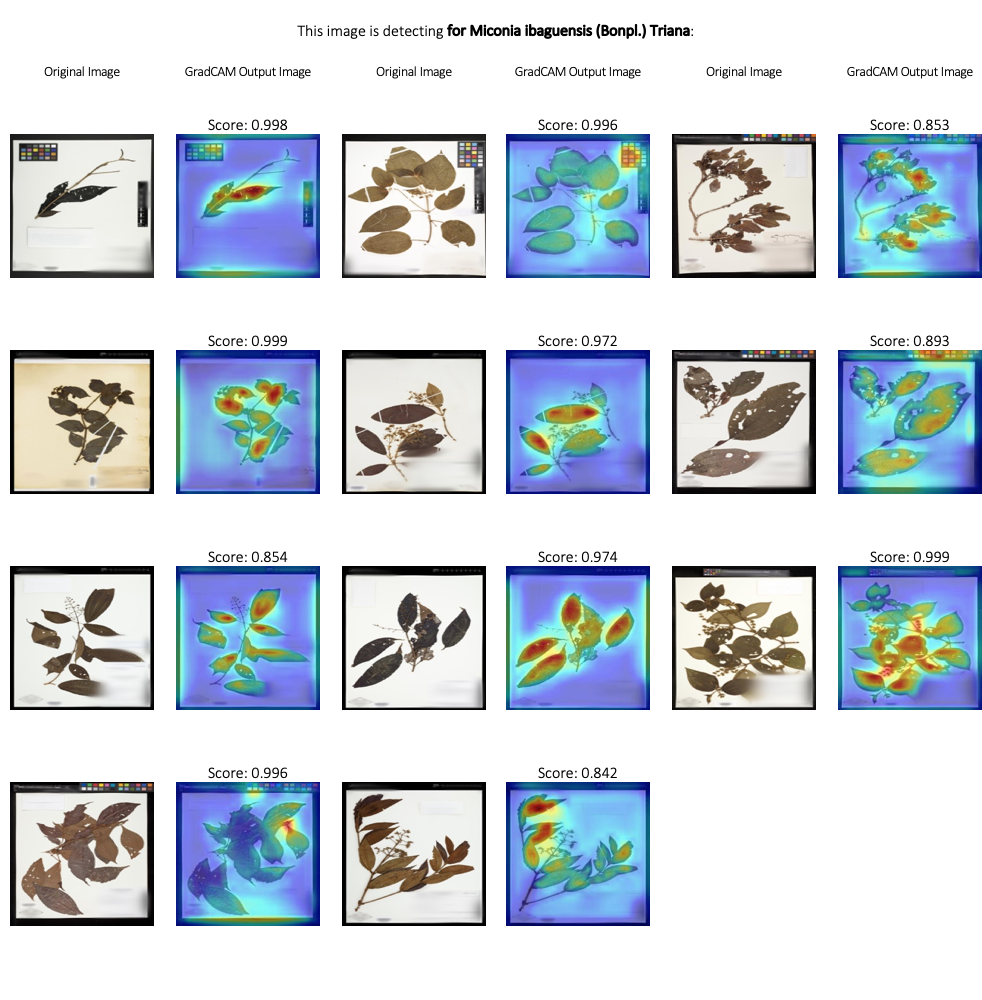

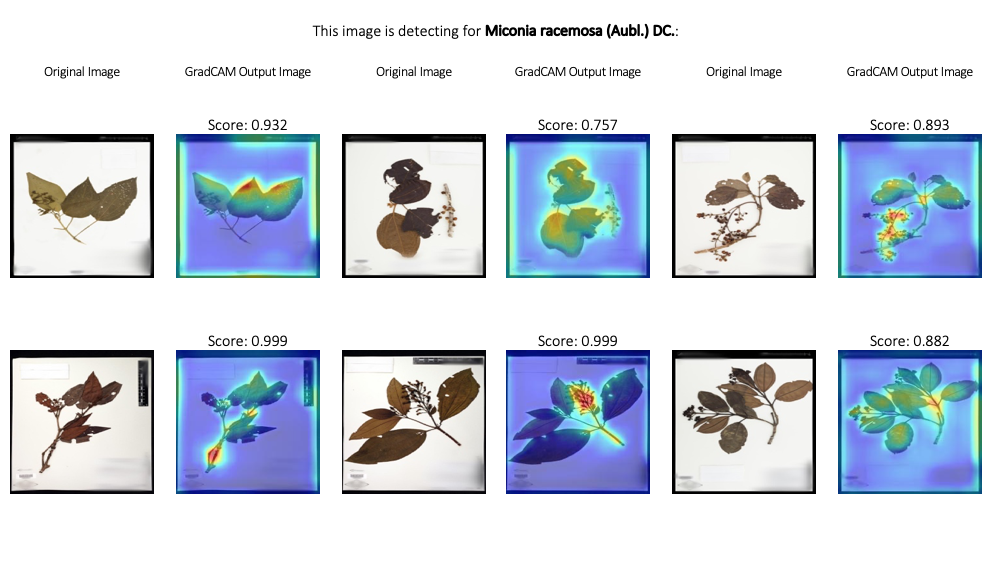

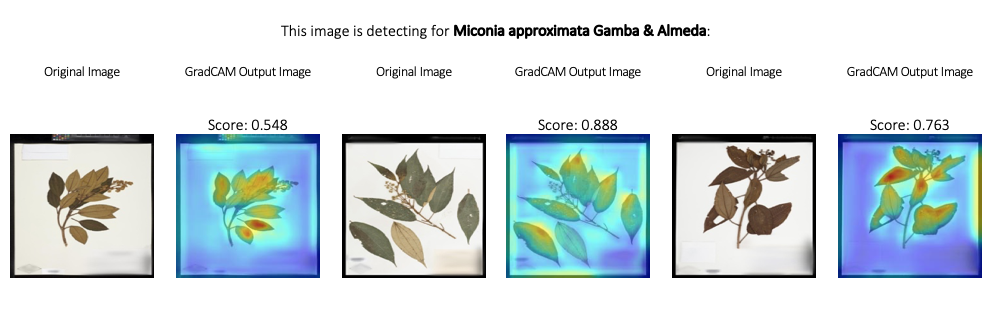

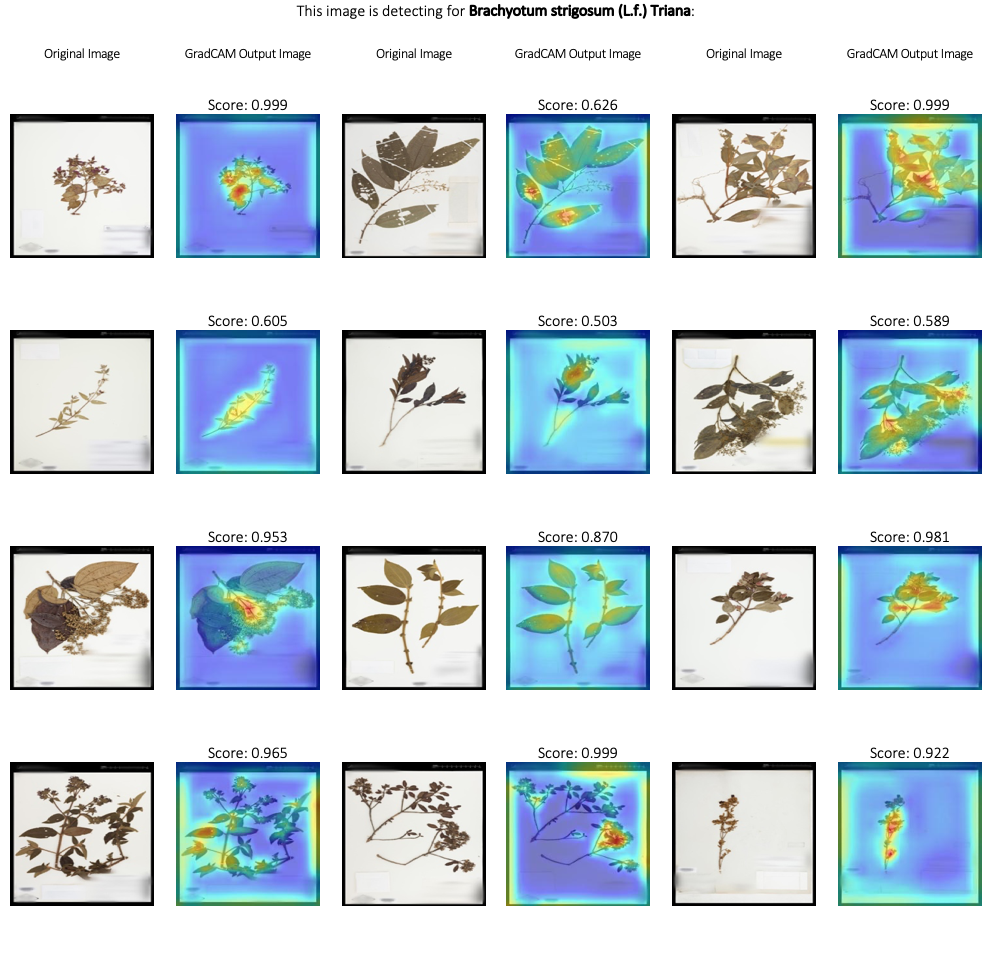

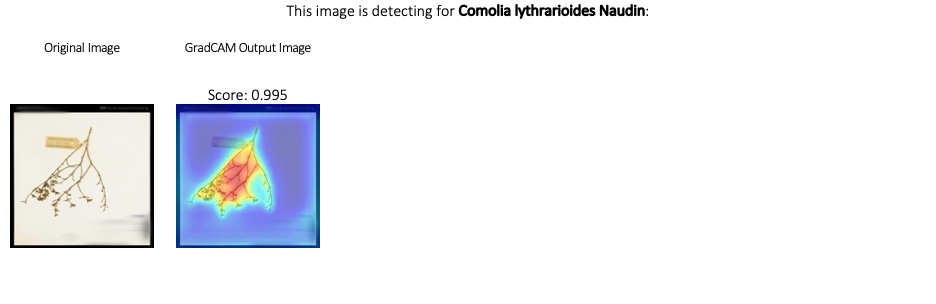

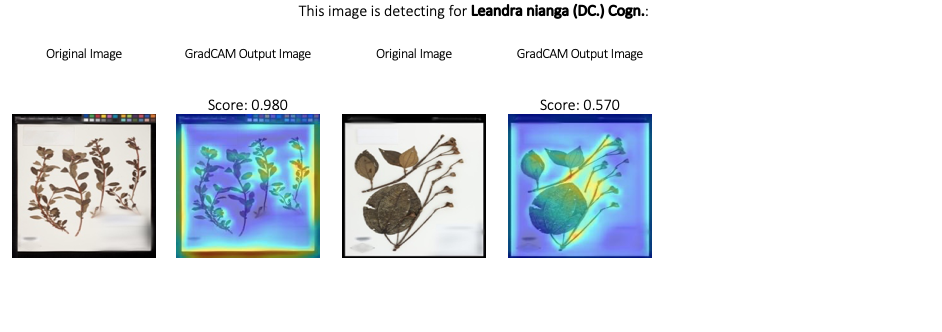